In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import numpy.matlib
import pickle
import random

from matplotlib import pyplot as plt
from scipy import linalg, sparse, stats
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

Initialize an English dictionary to filter words from the GloVe dataset. The GloVe dataset used has parsed over Wikipedia and thus contains a lot of noise. This is filtered using a spell check

In [2]:
import hunspell
spellchecker = hunspell.HunSpell('../data/hunspell/en_US.dic',
                                 '../data/hunspell/en_US.aff')

In [3]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'
TEXTURE_PATH = "/raid/data/datasets/broden1_384/c_texture.csv"

In [4]:
textures = pd.read_csv(TEXTURE_PATH, index_col = 0)
texture_list = list(textures['name'])

Read the concept activation vectors from the Broden dataset as a dictionary

In [5]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

### Import GloVe

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (n_samples x n_features). The original dataset contains about 400K words. All the words are run through a spell checker, if the word is not present in the English dictionary which was used, the word is removed. In total about 280000 words are removed from the GloVe dataset

In [6]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
    glove_words = list(embedding_dict.keys())
    
else:
    embedding_dict = {}
    glove_words = []
    glove_embedding_matrix = np.zeros((400000, 300))

    # parse through the GloVe data
    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for i, line in tqdm(enumerate(f)):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32').reshape(1,-1)
            
            # apply a spell check
            try:
                if spellchecker.spell(word):
                    embedding_dict[word] = vector
                    glove_embedding_matrix[i] = vector
                    glove_words.append(word)
            except:
                UnicodeEncodeError
                    
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # not all 400K rows are used as a certain amount of words was removed by the spellchecker, 
    # thus the unused rows are removed from the matrix
    glove_embedding_matrix = glove_embedding_matrix[:len(glove_words)]
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

In [7]:
print('The amount of words left in the GloVe dataset:', glove_embedding_matrix.shape[0])

The amount of words left in the GloVe dataset: 118327


### Preprocess CAVs

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [8]:
# list all Broden concepts
all_broden_concepts = list(cavs_broden.keys())

# remove duplicates from concept list (e.g. mountain-s is stored when mountain and mountain-s are both in the dataset)
# and remove the textures from the concepts
no_dups_concepts = [c for c in all_broden_concepts if c +'-s' not in all_broden_concepts and c not in texture_list]

In [9]:
print('Amount of CAVs left:', len(no_dups_concepts))

Amount of CAVs left: 649


In [10]:
# create a matrix of all cavs
cav_matrix = np.zeros((len(no_dups_concepts), cavs_broden[no_dups_concepts[0]]['cav'].shape[1]))
for i in range(len(no_dups_concepts)):
    cav = cavs_broden[no_dups_concepts[i]]['cav']
    cav_matrix[i] = cav

# remove the '-s' from the concepts if present 
broden_concepts = [c[:-2] if c[-2:] == '-s' else c for c in no_dups_concepts]

In [11]:
cav_matrix.shape

(649, 2048)

Extract concepts which have a CAV and a correspondence in the GloVe data. The index is stored to remove the unavailable concepts from the CAV matrix

In [12]:
# store the indices and the concepts with a correspondence in both datasets
embedding_idxs = [ix for ix, c in enumerate(broden_concepts) if c in embedding_dict.keys()]
embedding_concepts = [c for ix, c in enumerate(broden_concepts) if c in embedding_dict.keys()]

In [13]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  363


In [14]:
#extract the selected CAVs
cavs_with_embedding = cav_matrix[embedding_idxs]

In [15]:
cavs_with_embedding.shape

(363, 2048)

Create matrix with CAVs which do not have a matching word embedding

In [16]:
cav_no_glove = np.delete(cav_matrix, embedding_idxs, axis=0)
cav_no_glove_concepts = [conc for conc in broden_concepts if conc not in embedding_concepts]

Normalize the CAV matrices to norm-1

In [17]:
cavs_norm = normalize(cavs_with_embedding,axis=1)
cav_no_glove_norm = normalize(cav_no_glove, axis=1)

Add the matrices back together, the first 363 samples have a correspondence in the GloVe dataset, while the other part is used to better capture the structure of the CAV manifold

In [18]:
cavs_sorted = np.concatenate((cavs_norm, cav_no_glove_norm))
cavs_sorted_concept = embedding_concepts + cav_no_glove_concepts

### Include SoN image in the Manifold Alignment

In [19]:
# Read SoN info, where the ID equals the image name in the folder structure
son_info = pd.read_csv('../data/son_votes.csv', index_col = 0)

with open('../data/son_tensors.pickle', 'rb') as handle:
        son_tensors = pickle.load(handle)

From each score range (0-1, 1-2, ..., 9-10) 100 images are randomly sampled

In [20]:
son_manifold_imgs = []
for i in range(10):
    son_subset_idxs = list(son_info.query('Average > %s & Average <= %s' % (str(i), str(i+1))).index)
    son_random_idxs = random.sample(son_subset_idxs, 100)
    son_manifold_imgs.extend(son_random_idxs)

Create a matrix of the tensors of the random selected images

In [21]:
son_manifold_matrix = np.zeros((len(son_manifold_imgs), 2048))
for a, ix in enumerate(son_manifold_imgs):
    img_name_in_df = str(son_info.loc[ix, 'ID'])
    if ix >= 52642:
        ix += 1
    if ix >= 201047:
        ix += 1
    img_name_in_dict = son_tensors[str(ix)][0]
    
    if img_name_in_df != img_name_in_dict:
        print(a)
        
    else:
        img_tensor = son_tensors[str(ix)][2].numpy()
        son_manifold_matrix[a] = img_tensor
    

Normalize the data

In [22]:
son_manifold_matrix = normalize(son_manifold_matrix, axis=1)

### Add SoN to CAVs

In [23]:
cavs_sorted_son = np.concatenate((cavs_sorted, son_manifold_matrix))

In [24]:
cavs_sorted_son.shape

(1649, 2048)

### Preprocess GloVe

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [25]:
embeddings_with_cav = np.zeros((len(embedding_idxs), 300))
for i in range(len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i]].reshape(1,-1)
    embeddings_with_cav[i] = word_vec

In [26]:
embeddings_with_cav.shape

(363, 300)

Create matrix with GloVe embeddings which do not have a matching CAV

In [27]:
#Initiate a matrix with the required shape
glove_no_cav = np.zeros((len(glove_words) - len(embedding_concepts), 300))

# Also store the GloVe concept names (which do not have a match in CAV)
glove_no_cav_concept = []

idx = 0
for concpt in embedding_dict.keys():
    if concpt not in embedding_concepts:
        glove_no_cav_concept.append(concpt)
        concpt_vec = embedding_dict[concpt]
        glove_no_cav[idx] = concpt_vec
        idx +=1

In [28]:
glove_no_cav.shape

(117964, 300)

Normalize all data to norm-1

In [29]:
glove_norm = normalize(embeddings_with_cav,axis=1)
glove_no_cav_norm = normalize(glove_no_cav, axis=1)

Find the nearest neighbors of the GloVe embeddings which do have correspondence with CAVs. These are used in the manifold alignment to preserve the structure of the GloVe data

In [30]:
knn = NearestNeighbors(20, n_jobs=5)
knn.fit(glove_no_cav_norm)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=5, n_neighbors=20, p=2, radius=1.0)

Create a list of unique indices of the nearest neigbors to the GloVe embeddings which have a correspondence with a CAV

In [31]:
# takes about 3min to run
glove_neighbors = []
for k in tqdm(range(embeddings_with_cav.shape[0])):
    nn = knn.kneighbors(glove_norm[k,:].reshape(1,-1), return_distance=False)
    for n in nn.flatten():
        if n.item() not in glove_neighbors:
            glove_neighbors.append(n)

In [32]:
print('The number of unique neighours found:', len(glove_neighbors))

The number of unique neighours found: 4551


Extract the nearest neighbours from the data

In [33]:
glove_no_cav_nneigh = glove_no_cav_norm[glove_neighbors]
glove_no_cav_concept_nneigh = [glove_no_cav_concept[neigh] for neigh in glove_neighbors]

Concatenate the GloVe data together, the first 363 rows have correspondence in the CAV dataset. The other data is used the preserve the structure of the GloVe manifold during the alignment

In [34]:
glove_sorted = np.concatenate((glove_norm, glove_no_cav_nneigh))

---

In [35]:
print('Amount of CAVs used:', cavs_sorted_son.shape[0])
print('Amount of GloVes used:', glove_sorted.shape[0])

Amount of CAVs used: 1649
Amount of GloVes used: 4914


## Manifold alignment

Function to solve the generalized eigenvalue decomposition, which is a copy of the MatLab implementation of Devis Tuia

In [36]:
def gen_eig(A, B, option, n_eig):
    """
    Extracts generalized eigenvalues for problem A * U = B * U * landa
    """
    
    
    #n_eig = min(n_eig, np.linalg.matrix_rank(A), np.linalg.matrix_rank(B))
    
    B = (B + B.T) / 2
    R = B.shape[0]
    rango = np.linalg.matrix_rank(B)
    
    if rango == R:
        U = np.zeros((R, n_eig))
        D = np.zerose((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        for k in tqdm(range(n_eig)):
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option) #'a' are the eigenvectors in the matlab code
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            a = np.divide(a, np.sqrt(np.matmul(ab, a)))
            U[:,k] = a
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            dba = np.matmul(d, ba)
            A = A - np.matmul(dba, aTb)
        
        return U, D, n_eig
    
    else:
        d, v = sparse.linalg.eigs(B, rango)
        d = d.real
        v = v.real
        
        B = np.matmul(v.T, B)
        B = np.matmul(B, v)
        
        A = np.matmul(v.T, A)
        A = np.matmul(A, v)
        
        U2 = np.zeros((rango, n_eig))
        D = np.zeros((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        
        for k in tqdm(range(n_eig)):
            
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option)
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            aba = np.matmul(ab, a)
            a = np.divide(a, np.sqrt(aba))
            
            U2[:,k] = a.flatten()
        
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            
            dba = d * ba
            A = A - np.matmul(dba, aTb)
        
        U = np.matmul(v, U2)
        return U, D, n_eig

Transpose the data to column matrices

In [37]:
cavs_sorted_t = cavs_sorted_son.T
glove_sorted_t = glove_sorted.T

d1, n1 = cavs_sorted_t.shape
d2, n2 = glove_sorted_t.shape

In [38]:
tot_samples = n1+n2
tot_samples

6563

As the data is normalized to norm 1, the multiplication of the matrix with its transpose should show 1s along the diagonal

In [39]:
# plt.imshow(np.matmul(cavs_sorted_t.T, cavs_sorted_t))

To perform manifold allignment the MatLab code from Devis Tuia is followed: https://github.com/dtuia/KEMA/blob/master/general_routine/KMA.m

In [40]:
n_samples = len(embedding_concepts)
MU = 0.95
LAMBDA = 0.5

Compute the adjacency matrices for both the CAV and GloVe data

In [41]:
n_neighbors = 10
cav_knn_graph = kneighbors_graph(cavs_sorted_son, n_neighbors, mode = 'connectivity')
cav_knn_graph = cav_knn_graph.toarray()

In [42]:
glove_knn_graph = kneighbors_graph(glove_sorted, n_neighbors, mode = 'connectivity', n_jobs = 10)
glove_knn_graph = glove_knn_graph.toarray()

In [43]:
W = linalg.block_diag(cav_knn_graph, glove_knn_graph)

In [44]:
# plt.imshow(W)

Similarity matrix (Ws) encodes the samples belonging to the same class. In this research, there is a pairwise connections, every CAV only has a single match with a word embedding. This relation can be captured by the identity matrix. <br> The corresponding diagonal row sum matrix (Ds) results from summing Ws along the rows and converting the sums to a diagonal matrix.

In [45]:
Ws = np.zeros((n1+n2, n1+n2))

Ws1 = np.eye(n1)
Ws2 = np.eye(n2)
Ws3 = np.eye(n_samples)

Ws[:n1, :n1] = Ws1
Ws[n1:, n1:] = Ws2
Ws[n1:(n1+n_samples), :n_samples] = Ws3
Ws[:n_samples, n1:(n1+n_samples)] = Ws3

Ws = Ws + np.eye(Ws.shape[0])

# the identity matrices of Ws3 are not plotted on the imshow, but when plotting the right coordinates it does appear
#plt.imshow(Ws)
#plt.imshow(Ws[:400, n1:n1+400])

# should be True
Ws[0, n1] == 1

True

The dissimilarity matrix (Wd) encodes which samples do not belong to the same class. This is important to capture, otherwise every sample will end in the same location (the origin) as this will capture the similarity between the samples. In this research it is assumed that every sample is dissimilar from every other sample except from itself.

In [46]:
Wd = np.ones((n1+n2, n1+n2))
np.fill_diagonal(Wd, 0)

Wd1 = np.ones((n_samples, n_samples))
np.fill_diagonal(Wd1, 0)

Wd[:n_samples, n1:(n1+n_samples)] = Wd1
Wd[n1:(n1+n_samples), :n_samples] = Wd1

Wd = Wd + np.eye(Wd.shape[0])

#plt.imshow(Wd[:400, n1:n1+400])
#plt.imshow(Wd)

Wd[n1:n1+5, :5]

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

Normalize the data

In [47]:
Sws = sum(sum(Ws))
Swd = sum(sum(Wd))
Sw = sum(sum(W))

Ws = Ws / Sws * Sw
Wd = Wd / Swd * Sw

Extract the diagionals from the matrices

In [48]:
Dd = np.diag(np.sum(Wd, axis=1))
Ds = np.diag(np.sum(Ws, axis = 1))
D = np.diag(np.sum(W, axis=1))

In [49]:
D.shape

(6563, 6563)

Create the Laplacians which represent the structure of the data

In [50]:
Ls = Ds - Ws # graph Laplacian of similarity 
Ld = Dd - Wd # Laplacian of dissimilarity

L = D - W # Laplacian topology/geometry

In [51]:
A = ((1 - MU) * L + MU * Ls) + LAMBDA * np.eye(Ls.shape[0])
B = Ld

In [52]:
L.shape

(6563, 6563)

In [53]:
A.shape

(6563, 6563)

In [54]:
kernel_cav = np.matmul(cavs_sorted_t.T, cavs_sorted_t)
# #the kernel should have a diagonal of 1s
#plt.imshow(kernel_cav)

In [55]:
kernel_glove = np.matmul(glove_sorted_t.T, glove_sorted_t)
#plt.imshow(kernel_glove)

In [56]:
K = linalg.block_diag(kernel_cav, kernel_glove)

In [57]:
# plt.imshow(K)

In [58]:
KA = np.matmul(K,A)
KB = np.matmul(K,B)

KAK = np.matmul(KA, K)
KBK = np.matmul(KB, K)

In [59]:
# plt.imshow(KBK)

Solve the generalized eigenvalue decomposition

In [60]:
ALPHA, LAMBDA,n_eig = gen_eig(KAK, KBK, 'LM', 8)

Sort the eigenvalues and vectors

In [61]:
lambda_idxs = np.diag(LAMBDA).argsort()
LAMBDA = np.sort(np.diag(LAMBDA))
LAMBDA = LAMBDA.reshape(LAMBDA.shape[0],1)

In [62]:
LAMBDA

array([[0.63793204],
       [0.63918498],
       [0.64076582],
       [0.64295462],
       [0.6437806 ],
       [0.64645169],
       [0.65953006],
       [1.03714526]])

In [63]:
ALPHA = ALPHA[:, lambda_idxs]

Divide the eigenvectors over the 2 datasets

In [64]:
E1 = ALPHA[:n1, :] #eigenvectors for the first dataset (CAV)
E2 = ALPHA[n1:, :] #eigenvectors for the second dataset (GloVe)

Rotate axis is necessary

In [65]:
sourceXpInv = (-1 * np.matmul(E1.T, kernel_cav)).T
sourceXp = np.matmul(E1.T, kernel_cav).T
targetXp = np.matmul(E2.T, kernel_glove).T

In [66]:
sourceXpInv = stats.zscore(sourceXpInv)
sourceXp = stats.zscore(sourceXp)
targetXp = stats.zscore(targetXp)

In [67]:
sourceXpInv.shape

(1649, 8)

In [68]:
ErrRec = np.zeros((n1, ALPHA.shape[1]))
ErrRecInv = np.zeros((n1, ALPHA.shape[1]))

In [69]:
m1 = np.zeros((n1, ALPHA.shape[1]))
m1inv = np.zeros((n1, ALPHA.shape[1]))
m2 = np.zeros((n1, ALPHA.shape[1]))

In [70]:
cls = np.arange(n1).reshape(-1,1)

Compare the error of the inverted eigenvectors and the normal eigenvectors

In [71]:
for j in range(ALPHA.shape[1]):
    for i in range(n1):
        m1inv[i,j] = np.mean(sourceXpInv[i, j])
        #print('m1inv: ', m1inv)
        m1[i,j] = np.mean(sourceXp[i, j])
        #print('m1: ', m1)
        m2[i,j] = np.mean(targetXp[i, j])
        #print('m2: ', m2)
        
        ErrRec[i,j] = np.square(np.power(np.mean(sourceXp[i, j]) - np.mean(targetXp[i, j]), 2))
        
        ErrRecInv[i,j] = np.square(np.power(np.mean(sourceXpInv[i, j]) - np.mean(targetXp[i, j]),2))
        


In [72]:
Sc = ErrRec.max(axis=0) > ErrRecInv.max(axis=0)

In [73]:
Sc

array([ True,  True,  True,  True,  True,  True,  True,  True])

Invert axis if necessary

In [74]:
ALPHA[:n1, Sc] = ALPHA[:n1, Sc] * -1

In [79]:
NF = 100
nVectLin = NF

In [76]:
nVectLin = min(NF, np.linalg.matrix_rank(KBK))
nVectLin = min(nVectLin, np.linalg.matrix_rank(KAK))

KeyboardInterrupt: 

Transform data

In [80]:
T1 = cavs_sorted_t.shape[1]
T2 = glove_sorted_t.shape[1]

for Nf in range(nVectLin):
    E1 = ALPHA[:n1, :Nf+1]
    E2 = ALPHA[n1:, :Nf+1]
    
    Phi1toF = np.matmul(E1.T, kernel_cav)
    Phi2toF = np.matmul(E2.T, kernel_glove)
    
    Phi1TtoF = np.matmul(E1.T, kernel_cav) #KT1?
    Phi2TtoF = np.matmul(E2.T, kernel_glove) #KT2?
    
    m1 = np.mean(Phi1toF.T, axis = 0)
    m2 = np.mean(Phi2toF.T, axis = 0)
    s1 = np.std(Phi1toF.T, axis = 0)
    s2 = np.std(Phi2toF.T, axis =0)
    
    #Phi1toF = stats.zscore(Phi1toF).T
    #Phi2toF = stats.zscore(Phi2toF).T
    
    Phi1TtoF = np.divide((Phi1TtoF.T - np.matlib.repmat(m1, T1, 1)), 
                         np.matlib.repmat(s1, T1, 1)).T
    
    Phi2TtoF = np.divide((Phi2TtoF.T - np.matlib.repmat(m2, T2 ,1)),
                         np.matlib.repmat(s2, T2, 1)).T

In [98]:
Phi1TtoF_Lin = Phi1TtoF
Phi2TtoF_Lin = Phi2TtoF

# Phi1TtoF_Lin = scale(Phi1TtoF, axis=1)
# Phi2TtoF_Lin = scale(Phi2TtoF, axis=1)

# Phi1TtoF_Lin = normalize(Phi1TtoF_Lin, axis=0)
# Phi2TtoF_Lin = normalize(Phi2TtoF_Lin, axis=0)


# Phi1TtoF_Lin = normalize(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = normalize(Phi2TtoF, axis = 0)

# Phi1TtoF_Lin = stats.zscore(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = stats.zscore(Phi2TtoF, axis = 0)


In [99]:
np.std(Phi2TtoF_Lin, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [100]:
Phi1TtoF_Lin.shape

(8, 1649)

Text(-0.4183295360052441, 0.44254756585183674, 'mangrove')

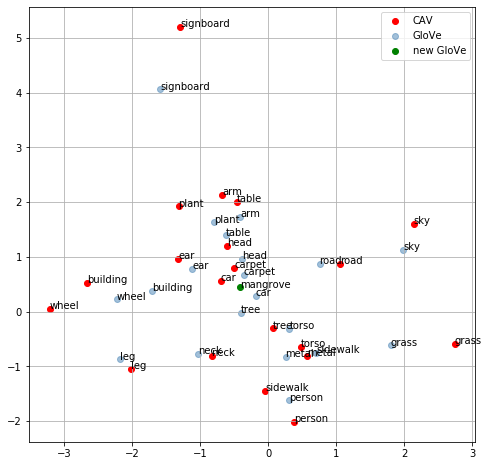

In [101]:
num_concepts = 20
new_glove = 3901 #

plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(Phi1TtoF_Lin[0,:num_concepts], Phi1TtoF_Lin[1,:num_concepts], label = 'CAV', color = 'red')
plt.scatter(Phi2TtoF_Lin[0,:num_concepts], Phi2TtoF_Lin[1,:num_concepts], label = 'GloVe', color = 'steelblue', alpha=0.5)
plt.scatter(Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples + new_glove], label = 'new GloVe', color='green')
#plt.xlim([-2.5,2.5])
#plt.ylim([-2.5, 2.5])


plt.legend()

for ii, txt in enumerate(embedding_concepts[:num_concepts]):
    plt.annotate(txt, (Phi1TtoF_Lin[0,ii], Phi1TtoF_Lin[1,ii]))
    plt.annotate(txt, (Phi2TtoF_Lin[0,ii], Phi2TtoF_Lin[1,ii]))

plt.annotate(glove_no_cav_concept_nneigh[new_glove], (Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples+new_glove]))

In [102]:
for ix, d in enumerate(glove_no_cav_concept_nneigh):
    print(ix, d)

0 skies
1 bright
2 blue
3 horizon
4 darkness
5 dark
6 sun
7 lights
8 heavens
9 starry
10 cloudless
11 night
12 lit
13 shadows
14 television
15 light
16 satellite
17 sunset
18 dawn
19 eyes
20 trees
21 pine
22 oak
23 shrubs
24 planted
25 trunks
26 bark
27 garden
28 eucalyptus
29 shrub
30 bushes
31 shade
32 flowering
33 willow
34 branches
35 maple
36 grove
37 leaf
38 cedar
39 seedlings
40 buildings
41 built
42 construction
43 houses
44 constructed
45 structure
46 build
47 brick
48 demolished
49 structures
50 apartment
51 constructing
52 renovated
53 residential
54 renovation
55 blocks
56 offices
57 facade
58 walls
59 rebuilt
60 someone
61 man
62 anyone
63 woman
64 one
65 actually
66 persons
67 people
68 else
69 somebody
70 only
71 if
72 kind
73 you
74 know
75 either
76 every
77 another
78 something
79 least
80 heads
81 assistant
82 chief
83 headed
84 director
85 deputy
86 chair
87 hand
88 then
89 former
90 back
91 coordinator
92 vice
93 executive
94 appointed
95 said
96 backs
97 the
98 ha

1172 gilded
1173 candlesticks
1174 candelabra
1175 paneling
1176 ceilings
1177 adorned
1178 beaded
1179 crucifix
1180 glittering
1181 necklace
1182 rhinestones
1183 rooftop
1184 overlooking
1185 foyer
1186 second-floor
1187 second-story
1188 paths
1189 toward
1190 way
1191 direction
1192 trajectory
1193 towards
1194 winding
1195 journey
1196 follow
1197 through
1198 approach
1199 step
1200 course
1201 steps
1202 heading
1203 clear
1204 passageway
1205 vestibule
1206 balustrades
1207 stairwells
1208 doorways
1209 cups
1210 champions
1211 finals
1212 tournament
1213 qualifying
1214 qualifiers
1215 matches
1216 championships
1217 semifinal
1218 semifinals
1219 quarterfinals
1220 final
1221 soccer
1222 quarterfinal
1223 trophy
1224 win
1225 trucks
1226 pickup
1227 tractor
1228 lorry
1229 minibus
1230 carrying
1231 vans
1232 flatbed
1233 airplanes
1234 jet
1235 planes
1236 jetliner
1237 airliner
1238 flight
1239 helicopter
1240 flying
1241 crashed
1242 crash
1243 airbus
1244 747
1245 737
12

2423 parlors
2424 karaoke
2425 bingo
2426 massage
2427 pizza
2428 salons
2429 salon
2430 cream
2431 saloons
2432 tattoo
2433 saloon
2434 billiard
2435 brothel
2436 cradles
2437 filth
2438 civilization
2439 humankind
2440 birthplace
2441 cherished
2442 rocking
2443 heartland
2444 damnation
2445 relics
2446 grave
2447 sacrilege
2448 tomb
2449 destiny
2450 beloved
2451 mankind
2452 anathema
2453 snatchers
2454 bluegrass
2455 modern
2456 celluloid
2457 locked
2458 resort
2459 surf
2460 golf
2461 seaside
2462 pompano
2463 pebble
2464 swimming
2465 shoreline
2466 surfing
2467 hotel
2468 bay
2469 canvases
2470 easels
2471 watercolor
2472 mural
2473 still-life
2474 stencils
2475 tempera
2476 watercolors
2477 cubist
2478 canvasses
2479 blackboard
2480 paints
2481 acrylic
2482 self-portrait
2483 airbrush
2484 darkroom
2485 collage
2486 collages
2487 monochrome
2488 fumes
2489 smoking
2490 burning
2491 smell
2492 acrid
2493 billowed
2494 flames
2495 cigarette
2496 cigarettes
2497 belching
2498 se

3824 silo
3825 sheds
3826 islets
3827 outcrop
3828 outcropping
3829 unpopulated
3830 outlying
3831 outcroppings
3832 pancreas
3833 barren
3834 reefs
3835 sliver
3836 disputed
3837 tiny
3838 atolls
3839 jutting
3840 slums
3841 shantytown
3842 dwellers
3843 shantytowns
3844 teeming
3845 shanty
3846 outskirts
3847 neighborhoods
3848 squatter
3849 inner-city
3850 suburb
3851 cite
3852 stronghold
3853 impoverished
3854 shanties
3855 bales
3856 alfalfa
3857 silage
3858 en
3859 ha
3860 y
3861 barley
3862 wheat
3863 grain
3864 es
3865 mas
3866 dice
3867 boo
3868 ah
3869 sin
3870 din
3871 hens
3872 pheasant
3873 rooster
3874 speckled
3875 goose
3876 bee
3877 cock
3878 mallard
3879 magpie
3880 egg
3881 nest
3882 shit
3883 pup
3884 lays
3885 sparrow
3886 villages
3887 rural
3888 hamlet
3889 towns
3890 villagers
3891 district
3892 municipality
3893 township
3894 inhabitants
3895 residents
3896 marshes
3897 meadows
3898 wetlands
3899 wetland
3900 marshland
3901 mangrove
3902 swamps
3903 swamp
3904 

## Explore new concepts related to scenicness

### Compare GloVe concepts to the clusters

In [ ]:
from sklearn import linear_model
import random
import heapq

### Transform GloVe data to the latent feature space

### Calculate a CAV for each cluster 

Load the data created in previous notebooks

In [ ]:
son_clusters = np.load('../data/son_clusters_50_2048.npy')
son_cluster_labels = np.load('../data/image_cluster_labels.npy')

son_matrix = np.load('../data/son_matrix.npy')
son_votes = pd.read_csv('../data/son_votes.csv', index_col = 0)

In [ ]:
son_matrix_norm = normalize(son_matrix)
son_matrix_norm_col = son_matrix_norm.T

In [ ]:
cav_cluster = {}

for i in np.unique(son_cluster_labels):
    
    # find images belonging to a cluster
    cluster_imgs = list(son_cluster_labels == i)
    cluster_idx = [ix for ix, img in enumerate(cluster_imgs) if img]
    
    # find images not labelled with the cluster
    negative_idx = [ix for ix, img in enumerate(cluster_imgs) if not img]
    
    # calculate the average scenicness score for the cluster
    scenicness_score = round(son_votes.loc[(son_cluster_labels == i),'Average'].mean(),2)
    
#     cluster_imgs_idx = [t+1 if t>= 52642 else t for t in cluster_idx]
#     cluster_imgs_idx = [t+1 if t>= 201047 else t for t in cluster_imgs_idx]
    
    # randomly sample positive images
    if len(cluster_idx) > 200:
        X_pos_idx = np.asarray(random.sample(cluster_idx, 200))
    elif len(cluster_idx) > 100:
        X_pos_idx = np.asarray(random.sample(cluster_idx, 100))
    else:
        X_pos_idx = np.asarray(random.sample(cluster_idx, 25))
        
    X_pos = son_matrix[X_pos_idx]
    y_pos = np.eye(X_pos.shape[0], 1)
    
    # randomly sample negative images
    X_neg_idx = np.asarray(random.sample(negative_idx, 400))
    X_neg = son_matrix[X_neg_idx]
    y_neg = np.zeros((X_neg.shape[0], 1))    
    
    # Concatenate the Xs and ys
    X = np.concatenate((X_pos, X_neg), axis = 0)
    y = np.concatenate((y_pos, y_neg), axis = 0).reshape(-1,)
    
    # Initialize linear classifier
    lm = linear_model.SGDClassifier()
    lm.fit(X, y)
    
    # Extract the cluster CAV and bias
    cluster_cav = lm.coef_
    cluster_bias = lm.intercept_
    
    # Store it in the dictionary
    cav_cluster['cluster_'+ str(i)] = {'scenic_score': scenicness_score,
                               'cav' : cluster_cav,
                               'bias' : cluster_bias}
    

### Transform the cluster CAVs to the common feature space

In [ ]:
cluster_cav_matrix = np.zeros((len(cav_cluster.keys()), cav_cluster[list(cav_cluster.keys())[0]]['cav'].shape[1]))

In [ ]:
for i, k in enumerate(cav_cluster.keys()):
    c_cav = cav_cluster[k]['cav']
    cluster_cav_matrix[i] = c_cav

In [ ]:
cluster_cav_matrix = normalize(cluster_cav_matrix, axis=1)

In [ ]:
#create the cluster kernel
cluster_kernel = np.matmul(cluster_cav_matrix, cavs_sorted_t)

In [ ]:
#transform the clusters to the common feature space
cluster_cav_transform = np.matmul(E1.T, cluster_kernel.T)

T3 = cluster_cav_matrix.shape[0]

m3 = np.mean(cluster_cav_transform.T, axis = 0)
std3 = np.mean(cluster_cav_transform.T, axis = 0)

cluster_cav_transform = np.divide((cluster_cav_transform.T - np.matlib.repmat(m3, T3, 1)), 
                         np.matlib.repmat(std3, T3, 1)).T

In [ ]:
# Initialize a nearest neighbor algorithm
cluster_knn = NearestNeighbors(10)
cluster_knn.fit(Phi1TtoF.T)

In [ ]:
# Find the nearest neighbors from the CAV data to the clusters
for j, cl in enumerate(cav_cluster.keys()):
    nn_cl = cluster_knn.kneighbors(cluster_cav_transform.T[j].reshape(1,-1), return_distance=False)
    cav_cluster[cl]['neighbors'] = nn_cl

In [ ]:
# print the clusters and the nearest neighbors
for cl in cav_cluster.keys():
    print(cl)
    print('------------')
    neigh = cav_cluster[cl]['neighbors'][0]
    for n in neigh:
        print(cavs_sorted_concept[n.item()])
    print('\n')

In [ ]:
all_clusters = list(cav_cluster.keys())

In [ ]:
glove_transform.shape

In [ ]:
cluster_score = np.zeros((glove_transform.shape[1], len(son_clusters)))

In [ ]:
for i in tqdm(range(len(son_clusters))):
    cluster_cav = cav_cluster['cluster_' + str(i)]['cav']
    cluster_bias = cav_cluster['cluster_' + str(i)]['bias']
    for j in range(glove_transform.shape[1]):
        score = np.dot(cluster_cav, glove_transform[:,j]) + cluster_bias
        cluster_score[j, i] = score

cluster_score_df = pd.DataFrame(cluster_score, columns = all_clusters)


In [ ]:
cluster_score_df.index = embedding_dict.keys()

In [ ]:
broden_cluster_score = cluster_score_df.loc[embedding_concepts,:]

In [ ]:
ii = 36
clus = 'cluster_' + str(ii)

In [ ]:
ixds_glove = np.asarray(broden_cluster_score[clus]).argsort()[::-1]

In [ ]:
for i in range(10):
    print(embedding_concepts[ixds_glove[i]])

### Convert GloVe to CAV

The GloVe concepts are transformed to CAVs and then each new GloVe concepts is compared to scenicness using Kendalls Tau rank correlation

In [ ]:
test_data = glove_no_cav[1000:10000].T
test_data = normalize(test_data, axis=0)
test_data.shape

In [ ]:
test_kernel = np.matmul(test_data.T, glove_sorted_t)
test_kernel.shape

In [ ]:
test_transform = np.matmul(E2.T, test_kernel.T)
test_transform.shape

In [ ]:
T3 = test_data.shape[1]

In [ ]:
new_concepts_in_latent = np.divide((test_transform.T - np.matlib.repmat(m2, T3 ,1)),
                         np.matlib.repmat(s2, T3, 1)).T

In [ ]:
new_c_to_cav = np.multiply((new_concepts_in_latent.T + np.matlib.repmat(m1,T3,1)),
                          np.matlib.repmat(s1, T3, 1)).T

In [ ]:
new_concepts_cav = np.matmul(np.linalg.pinv(E1.T), new_c_to_cav)
new_concepts_cav.shape

In [ ]:
new_concepts_cav = np.matmul(np.linalg.pinv(cavs_sorted_t).T, new_concepts_cav)

In [ ]:
new_concepts_cav.shape

---

In [ ]:
with open('../data/son_tensors.pickle', 'rb') as handle:
        son_tensors = pickle.load(handle)

In [ ]:
concept_score_matrix = np.zeros((len(son_tensors), new_concepts_cav.shape[1]))

In [ ]:
for c in tqdm(range(new_concepts_cav.shape[1])):
    son_img_tensor = son_tensors[list(son_tensors.keys())[i]][2].numpy()
    
    for i in range(len(son_tensors)):
        concept_score = np.dot(new_concepts_cav[:,c], son_img_tensor)
        concept_score_matrix[i][c] = concept_score
        
np.save('../data/glove_concept_scores.npy', concept_score_matrix)

In [ ]:
concept_score_matrix.shape

In [ ]:
new_glove_concepts = glove_no_cav_concept[1000:10000]
scenic_score = np.asarray(son_votes.Average)

In [ ]:
kendall_tau_glove = {'tau': []}
                    
for ix, c in tqdm(enumerate(new_glove_concepts)):
    c_score = concept_score_matrix[:, ix] * 1000
    tau, p_value = stats.kendalltau(c_score, scenic_score)
    kendall_tau_glove['tau'].append(tau)

In [ ]:
kendall_tau_glove['concept'] = new_glove_concepts

In [ ]:
kendall_tau_glove_df = pd.DataFrame.from_dict(kendall_tau_glove)

In [ ]:
kendall_tau_glove_df.sort_values(by=['tau'], ascending=True, inplace = True)

In [ ]:
kendall_tau_glove_df

In [ ]:
concept_score_matrix[:, 1]